In [1]:
from SourceCodeTools.code.data.dataset.Dataset import SourceGraphDataset, read_or_create_gnn_dataset
from SourceCodeTools.models.graph.train.sampling_multitask2 import SamplingMultitaskTrainer
from random import random

from SourceCodeTools.models.training_config import get_config, save_config, load_config
from SourceCodeTools.code.data.dataset.Dataset import SourceGraphDataset, filter_dst_by_freq
from SourceCodeTools.models.graph.train.sampling_multitask2 import training_procedure, SamplingMultitaskTrainer
from SourceCodeTools.models.graph.train.objectives.NodeClassificationObjective import NodeClassifierObjective
from SourceCodeTools.models.graph.train.objectives.SubgraphClassifierObjective import SubgraphAbstractObjective, \
    SubgraphClassifierObjective, SubgraphEmbeddingObjective
from SourceCodeTools.models.graph.train.objectives.SubgraphEmbedderObjective import SubgraphEmbeddingObjective, \
    SubgraphMatchingObjective
from SourceCodeTools.models.graph.train.utils import get_name, get_model_base
from SourceCodeTools.models.graph import RGGAN
from SourceCodeTools.tabular.common import compact_property
from SourceCodeTools.code.data.file_utils import unpersist
from SourceCodeTools.models.graph.train.objectives.SCAAClassifierObjetive import SCAAClassifierObjective


import dgl
import torch
import numpy as np
from argparse import Namespace
from torch import nn
from datetime import datetime
from os.path import join
from functools import partial

In [2]:
data_path = "./examples/one_vs_10/with_ast"
subgraph_partition = join(data_path, "subgraph_partition.json.bz2")
tokenizer_path = "sentencepiece_bpe.model"

config = get_config(
    subgraph_id_column="file_id",
    data_path=data_path,
    model_output_dir=data_path,
    subgraph_partition=subgraph_partition,
    tokenizer_path=tokenizer_path,
    objectives="scaa_match",
    measure_scores=True,
    dilate_scores=1,
    epochs=1000,
)

In [3]:
! ls ./examples/new_scaa/with_ast

common_edges.json.bz2        node_names.json.bz2
common_filecontent.json.bz2  RGGAN_100.zip
common_nodes.json.bz2        RGGAN-2022-05-12-20-00-44-925831/
common_offsets.json.bz2      RGGAN-2022-05-17-20-48-59-920596/
full_scaa.zip                subgraph_partition.json.bz2


In [4]:
base_path = data_path + '/u-pooling 100 epochs exp 3/'

In [5]:
# dataset = read_or_create_gnn_dataset(
#     args={**config["DATASET"], **config["TOKENIZER"]},
#     model_base=base_path, restore_state=True
# )

In [6]:
dataset = SourceGraphDataset(
    **{**config["DATASET"], **config["TOKENIZER"]}
)

/home/alina/workspace/scaa/method-embedding/SourceCodeTools/code/data/dataset/Dataset.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.nodes = self.nodes.append(new_nodes, ignore_index=True)
/home/alina/workspace/scaa/method-embedding/SourceCodeTools/code/data/dataset/Dataset.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.edges = self.edges.append(new_edges, ignore_index=True)


In [7]:
config

{'DATASET': {'data_path': './examples/one_vs_10/with_ast',
  'train_frac': 0.9,
  'filter_edges': None,
  'min_count_for_objectives': 5,
  'self_loops': False,
  'use_node_types': False,
  'use_edge_types': False,
  'no_global_edges': False,
  'remove_reverse': False,
  'custom_reverse': None,
  'restricted_id_pool': None,
  'random_seed': None,
  'subgraph_id_column': 'file_id',
  'subgraph_partition': './examples/one_vs_10/with_ast/subgraph_partition.json.bz2'},
 'TRAINING': {'model_output_dir': './examples/one_vs_10/with_ast',
  'pretrained': None,
  'pretraining_phase': 0,
  'sampling_neighbourhood_size': 10,
  'neg_sampling_factor': 3,
  'use_layer_scheduling': False,
  'schedule_layers_every': 10,
  'elem_emb_size': 100,
  'embedding_table_size': 200000,
  'epochs': 1000,
  'batch_size': 128,
  'learning_rate': 0.001,
  'objectives': 'scaa_match',
  'save_each_epoch': False,
  'save_checkpoints': True,
  'early_stopping': False,
  'early_stopping_tolerance': 20,
  'force_w2v_ns':

In [8]:
config['TRAINING']['model_base_path'] = base_path
config['TRAINING']['batch_size'] = 64

config['MODEL']["activation"] = eval(f"nn.functional.{config['MODEL']['activation']}")
# config['TRAINING']['objectives'] = ['subgraph_match']

In [9]:
model = SamplingMultitaskTrainer(dataset=dataset, 
                                 model_name=RGGAN,
                                 model_params=config["MODEL"],
                                 trainer_params=config["TRAINING"], 
                                 restore=True)

Number of nodes 17892


2022-06-07 11:04:58.847780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 11:04:58.847811: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
import pandas as pd
keys = list(model.objectives[0].subgraph_mapping.keys())
print(keys[-1] is pd.NA)
len(model.objectives[0].subgraph_mapping[keys[-1]])

True


0

In [11]:
embds = model.compute_subgraph_embeddings(model.objectives[0])

Computer Subgraph Embeddings:   0%|                                                                                      | 0/2 [00:00<?, ?it/s]/home/alina/.local/lib/python3.9/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Computer Subgraph Embeddings: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


In [12]:
ids, emb = embds
print(ids.shape, emb.shape)

torch.Size([90]) torch.Size([90, 100])


In [13]:
len(np.unique(ids))

90

In [14]:
dataset = unpersist(join('examples/one_vs_10/with_ast', "common_filecontent.json.bz2"))
dataset = dataset[['id', 'task', 'user']]

In [15]:
# task 1 - show on task-level
from sklearn.manifold import TSNE

In [16]:
x = TSNE(n_components=2).fit_transform(emb)
ids = ids.tolist()

/home/alina/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/alina/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [17]:
train_ids = dataset[dataset.task < 7].id.values
test_ids = dataset[dataset.task >= 7].id.values

train_indexes = np.where([n in train_ids for n in ids])[0]
test_indexes = np.where([n not in train_ids for n in ids])[0]
x_train = emb[train_indexes]
x_test = emb[test_indexes]

y_train = [dataset[dataset.id == id].user.values[0] for id in train_ids]
y_test = [dataset[dataset.id == id].user.values[0] for id in test_ids]

print(x_train.shape, x_test.shape, len(y_train), len(y_test))

torch.Size([70, 100]) torch.Size([20, 100]) 70 20


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('test acc', accuracy_score(y_test, y_pred))
y_pred = knn.predict(x_train)
print('train acc', accuracy_score(y_train, y_pred))

test acc 0.15
train acc 0.2571428571428571


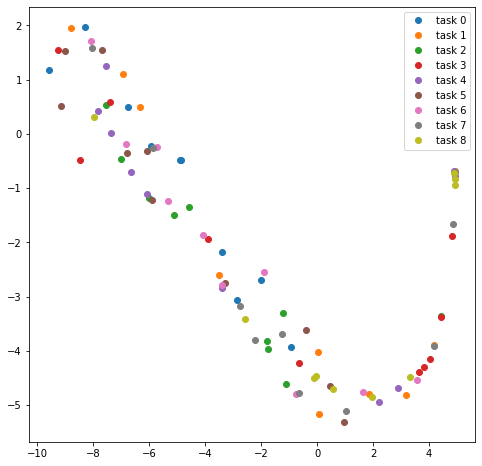

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for task in range(9):
    good_ids = dataset[dataset.task == task].id.values
    indexes = np.where([n in good_ids for n in ids])[0]
    xs = x[indexes].T
    plt.plot(xs[0], xs[1], 'o', label='task ' + str(task))
    
plt.legend()
plt.savefig('SMALLscaaU_pooling100task')

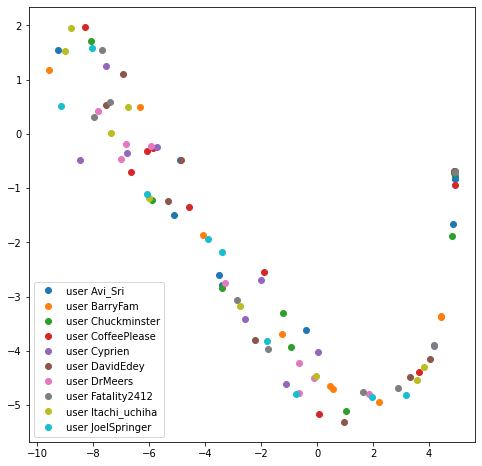

In [21]:
# task 2 - show on user-level
plt.figure(figsize=(8, 8))
users = np.unique(dataset.user.values)
for user in users[0:10]:
    good_ids = dataset[dataset.user == user].id.values
    indexes = np.where([n in good_ids for n in ids])[0]
    xs = x[indexes].T
    plt.plot(xs[0], xs[1], 'o', label='user ' + user)
    
plt.legend()
plt.savefig('SMALLscaaU_pooling100user')